In [1]:
# Copyright © 2025 Amlan Chatterjee. All rights reserved.

"""
RADAR SIGNAL PROCESSING TUTORIAL - Part 4
==========================================
CFAR Detection: Classical Algorithms (CA-CFAR & OS-CFAR)

Learning Objectives:
- Understand why fixed thresholds fail in radar detection
- Implement CA-CFAR (Cell-Averaging CFAR)
- Implement OS-CFAR (Ordered Statistics CFAR)
- Compare performance in different scenarios
- Learn proper evaluation metrics for detection algorithms

Prerequisites: Parts 1-3 (RDM generation, noise characteristics)
Estimated time: 2-3 hours

Author's Note: This is a standalone tutorial. All RDM generation is self-contained.

WHAT'S NEW IN THIS VERSION:
- Soft ground truth (Gaussian spread) instead of binary masks
- Connected-component based evaluation (evaluate_detections function)
- More realistic performance metrics
- Comprehensive annotations showing interpretation methods
"""

"\nRADAR SIGNAL PROCESSING TUTORIAL - Part 4\n==========================================\nCFAR Detection: Classical Algorithms (CA-CFAR & OS-CFAR)\n\nLearning Objectives:\n- Understand why fixed thresholds fail in radar detection\n- Implement CA-CFAR (Cell-Averaging CFAR)\n- Implement OS-CFAR (Ordered Statistics CFAR)\n- Compare performance in different scenarios\n- Learn proper evaluation metrics for detection algorithms\n\nPrerequisites: Parts 1-3 (RDM generation, noise characteristics)\nEstimated time: 2-3 hours\n\nAuthor's Note: This is a standalone tutorial. All RDM generation is self-contained.\n\nWHAT'S NEW IN THIS VERSION:\n- Soft ground truth (Gaussian spread) instead of binary masks\n- Connected-component based evaluation (evaluate_detections function)\n- More realistic performance metrics\n- Comprehensive annotations showing interpretation methods\n"

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from scipy.fft import fft2, fftshift
from scipy.ndimage import label, generate_binary_structure
import warnings
import os
warnings.filterwarnings('ignore')

# Visualization setup
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Imports successful")
print("=" * 70)
print("PART 4: CFAR DETECTION - CLASSICAL ALGORITHMS")
print("=" * 70)

✓ Imports successful
PART 4: CFAR DETECTION - CLASSICAL ALGORITHMS


---
# Part 4: CFAR Detection - Classical Algorithms

## Quick Recap: Where We Are

From Parts 1-3, you understand:
- ✅ **Range-Doppler Map (RDM)**: 2D image showing targets at specific range and velocity
- ✅ **Noise**: Random variations that obscure weak targets
- ✅ **Clutter**: Strong returns from stationary objects (ground, buildings)
- ✅ **Micro-Doppler**: Helps classify what the target is (drone vs bird)

## The Next Challenge: Automatic Detection

**Human vs Computer:**
- YOU can look at an RDM and spot the bright spots (targets)
- But a computer needs an ALGORITHM to automatically find them

**This is what Part 4 solves: Constant False Alarm Rate (CFAR) Detection**

---
# 1. The Detection Problem: Why Fixed Thresholds Fail

## Core Concept: What is Detection?

**Detection = Making a binary decision for each cell in the RDM:**
```
If cell_value > threshold:
    Decision: "TARGET PRESENT" (Detection)
else:
    Decision: "NO TARGET" (Noise)
```

## Key Terms We'll Use (Explained Now):

**1. Threshold**: 
   - A cutoff value for decision making
   - Example: "If signal strength > 30 dB, declare target"
   - Units: Usually dB (decibels)

**2. dB (Decibel)**:
   - Logarithmic scale for power or amplitude
   - Formula: dB = 10 * log10(Power)
   - Why? Radar signals span huge ranges (1 to 1,000,000,000)
   - Example: 30 dB = 1000x power, 60 dB = 1,000,000x power

**3. SNR (Signal-to-Noise Ratio)**:
   - How much stronger is the signal than the noise?
   - SNR = Signal_Power / Noise_Power
   - In dB: SNR_dB = 10 * log10(Signal_Power / Noise_Power)
   - Example: SNR = 20 dB means signal is 100x stronger than noise

**4. Pfa (Probability of False Alarm)**:
   - Chance that noise alone triggers a detection
   - Example: Pfa = 1e-6 means 1 in a million noise-only cells will falsely detect
   - Lower Pfa = fewer false alarms, but might miss weak targets

**5. Pd (Probability of Detection)**:
   - Chance that a real target is detected
   - Example: Pd = 0.9 means we catch 90% of targets
   - Higher Pd = better, but usually causes higher Pfa

**6. RCS (Radar Cross Section)**:
   - How "reflective" a target is to radar
   - Units: square meters (m²)
   - Examples: Bird = 0.001 m², Drone = 0.01 m², Aircraft = 10 m²

## The Problem Illustrated

Imagine an RDM with:
- **Region A**: Clear sky, low noise floor (say, 10 dB)
- **Region B**: Near ground clutter, high noise floor (say, 50 dB)
- **Targets**: Weak drone at 15 dB in Region A, strong target at 55 dB in Region B

**If you set threshold = 30 dB:**
- ❌ Region A: Drone (15 dB) < 30 dB → MISSED DETECTION
- ❌ Region B: Many noise spikes (45-50 dB) > 30 dB → FALSE ALARMS

**If you set threshold = 20 dB:**
- ✓ Region A: Drone detected
- ❌ Region B: MASSIVE false alarms from clutter

**Conclusion: Fixed threshold CANNOT work because noise floor varies spatially!**

---

In [3]:
def create_synthetic_rdm(num_doppler=128,
                         num_range=256,
                         targets=None,
                         noise_floor_db=-40,
                         clutter_regions=None):
    """
    Generate a synthetic Range-Doppler Map for testing CFAR algorithms

    WHY THIS METHOD EXISTS:
    - Makes tutorial self-contained (don't need Part 2 code)
    - Full control over targets, noise, clutter for testing
    - Can create specific scenarios to prove algorithm behavior

    WHAT IT PROVES:
    - RDMs have spatially-varying noise floors
    - Clutter creates high-noise regions
    - Targets can be weak or strong relative to local noise

    Parameters:
    -----------
    num_doppler : int
        Number of Doppler (velocity) bins
    num_range : int
        Number of range bins
    targets : list of dict
        Each dict: {'range_bin': int, 'doppler_bin': int, 'snr_db': float}
        Example: {'range_bin': 100, 'doppler_bin': 64, 'snr_db': 15}
    noise_floor_db : float
        Base noise level in dB (default: -40 dB)
    clutter_regions : list of dict
        Each dict: {'range_start': int, 'range_end': int,
                    'doppler_center': int, 'strength_db': float}

    Returns:
    --------
    rdm : ndarray
        Range-Doppler Map [num_doppler x num_range] in linear power scale
    rdm_dB : ndarray
        Same RDM in dB scale (for visualization)
    ground_truth_soft : ndarray (float, 0-1)
        SOFT ground truth showing target spread with Gaussian profile
        - Center cell = 1.0 (peak of target)
        - Neighboring cells = exp(-(distance²)/2) (Gaussian falloff)
        - Non-target cells = 0.0

        WHY SOFT GROUND TRUTH?
        Real radar targets aren't point sources - they spread across multiple cells
        due to:
        1. Radar resolution limits (range/Doppler resolution)
        2. Target physical extent (larger targets = more spread)
        3. Signal processing (windowing causes spectral leakage)

        The soft ground truth models this reality, allowing more accurate
        performance evaluation than binary masks.

    Educational Notes:
    ------------------
    - Noise floor: The average power level of noise in the RDM
    - Linear scale: Actual power values (e.g., 0.001, 1.0, 1000.0)
    - dB scale: Logarithmic (e.g., -30 dB, 0 dB, 30 dB) - easier to visualize
    - Soft ground truth: Continuous values (0-1) representing target spread
    """

    # Initialize with noise floor (convert dB to linear power)
    noise_linear = 10**(noise_floor_db / 10)

    # Create base noise (Rayleigh distributed - typical for radar)
    rdm = np.random.rayleigh(scale=np.sqrt(noise_linear/2),
                             size=(num_doppler, num_range))

    # Soft ground truth (float values 0-1 showing target spread)
    ground_truth_soft = np.zeros((num_doppler, num_range), dtype=float)

    # Add clutter regions
    if clutter_regions is not None:
        for clutter in clutter_regions:
            r_start = clutter['range_start']
            r_end = clutter['range_end']
            d_center = clutter['doppler_center']
            strength_db = clutter['strength_db']

            clutter_linear = 10**(strength_db / 10)

            for d in range(num_doppler):
                doppler_profile = np.exp(-((d - d_center)**2) / (2 * 5**2))
                rdm[d, r_start:r_end] += clutter_linear * doppler_profile * \
                                          np.random.rand(r_end - r_start)

    # Add targets with Gaussian spread
    if targets is not None:
        for tgt in targets:
            r_bin = tgt['range_bin']
            d_bin = tgt['doppler_bin']
            snr_db = tgt['snr_db']

            local_noise = rdm[d_bin, r_bin]
            target_power = local_noise * 10**(snr_db / 10)

            # Add target (spread over 3x3 cells for realism)
            for dd in range(-1, 2):
                for dr in range(-1, 2):
                    d_idx = d_bin + dd
                    r_idx = r_bin + dr
                    if 0 <= d_idx < num_doppler and 0 <= r_idx < num_range:
                        # Gaussian spread for both RDM and ground truth
                        spread = np.exp(-(dd**2 + dr**2) / 2) # We add both dd and dr squared because of 2 Dimensions
                        rdm[d_idx, r_idx] += target_power * spread
                        ground_truth_soft[d_idx, r_idx] = spread

    # Convert to dB for visualization
    rdm_dB = 10 * np.log10(rdm + 1e-10)

    return rdm, rdm_dB, ground_truth_soft

In [4]:
def evaluate_detections(detections, ground_truth_soft, threshold=0.5):
    """
    Match CFAR detections to ground truth targets using connected-component analysis

    WHY THIS METHOD EXISTS:
    Traditional pixel-wise comparison has a fundamental problem:
    - Targets spread across multiple cells (3x3 in our case)
    - A detection in ANY cell of the target spread should count as success
    - Pixel-wise comparison counts neighboring detections as "false alarms"

    SOLUTION: Connected-Component Matching
    1. Group ground truth cells into "target blobs"
    2. Group detection cells into "detection blobs"
    3. Match blobs: If detection blob overlaps target blob → TRUE POSITIVE
    4. Unmatched detection blobs → FALSE ALARMS
    5. Unmatched target blobs → MISSED DETECTIONS

    CONNECTIVITY DEFINITION:
    Use FULL connectivity (all neighbors within distance 1 are connected):
    - 2D: 8-connectivity (horizontal, vertical, AND diagonal neighbors)
    - 3D: 26-connectivity (all face, edge, and corner neighbors)
    - N-D: (3^N - 1)-connectivity (all surrounding hypercells)

    WHY DO WE CARE ABOUT FULL CONNECTIVITY?
    Radar targets physically spread across adjacent cells. Any cells within
    distance 1 should be considered part of the same physical target, including
    diagonals. This matches the physical reality of target extent and radar
    resolution limitations.

    INTERPRETATION:
    This method asks: "Did we detect the TARGET?" not "Did we detect this exact pixel?"
    Much more realistic for operational radar systems.

    Parameters:
    -----------
    detections : ndarray (bool), shape (M, N) or (M, N, P) or N-D
        Binary detection map from CFAR algorithm
        True = detection declared at this cell
        Works for any dimensionality (2D, 3D, N-D)
    ground_truth_soft : ndarray (float, 0-1), same shape as detections
        Soft ground truth with Gaussian target spread
        Values: 0.0 (no target) to 1.0 (target center)
    threshold : float, default=0.5
        Threshold for converting soft ground truth to binary
        Default 0.5 means cells with >50% target energy count as "target"

    Returns:
    --------
    n_targets : int
        Number of true targets in ground truth
    n_detected : int
        Number of targets successfully detected (True Positives at target level)
    n_false_alarms : int
        Number of detection blobs not on any target (False Positives)
    n_missed : int
        Number of targets not detected (Missed Detections)

    Educational Notes:
    ------------------
    Connected components = grouping adjacent True cells into "blobs"
    Example (2D with 8-connectivity):
        [0 0 1 0 0]     Blob 1: pixels (0,2), (1,2), (1,3)
        [0 0 1 1 0]  →  All connected via horizontal/vertical/diagonal
        [0 0 0 0 0]     Blob 2: pixel (3,1) - isolated
        [0 1 0 0 0]

    In radar: Each blob = one physical object
    """
    #
    # Step 1: Convert soft ground truth to binary mask
    # gt_binary = binary mask where True = part of a target (energy > threshold)
    gt_binary = ground_truth_soft > threshold

    # Step 2: Determine dimensionality and create connectivity structure
    # ndim = number of dimensions in the array
    #   - For 2D RDM (128, 256): ndim = 2
    #   - For 3D volume (128, 256, 64): ndim = 3
    #   - Automatically adapts to any N-D array
    ndim = detections.ndim

    # structure = connectivity mask defining which neighbors count as "connected"
    # generate_binary_structure(ndim, connectivity=2) creates:
    #   - 2D: 3x3 array of all 1s (8 neighbors)
    #   - 3D: 3x3x3 array of all 1s (26 neighbors)
    #   - N-D: (3^ndim - 1) neighbors
    # connectivity=2 means "full" connectivity (includes all diagonal/corner neighbors)
    structure = generate_binary_structure(ndim, connectivity=2)

    # Step 3: Label connected components in ground truth
    # target_labels = array where each target blob gets unique integer ID (1, 2, 3, ...)
    #   - Same shape as gt_binary
    #   - 0 = no target, 1 = first target, 2 = second target, etc.
    # n_targets = total number of distinct target blobs found
    target_labels, n_targets = label(gt_binary, structure=structure)

    # Step 4: Label connected components in detections
    # detection_labels = array where each detection blob gets unique integer ID
    # n_blobs = total number of distinct detection blobs found
    detection_labels, n_blobs = label(detections, structure=structure)

    # Step 5: Match detection blobs to target blobs
    detected_targets = set()   # Set of target IDs that have been detected
    false_alarm_blobs = set()  # Set of detection blob IDs that don't match any target

    # Loop through each detection blob
    for blob_id in range(1, n_blobs + 1):
        # blob_mask = boolean array, True where this detection blob exists
        blob_mask = (detection_labels == blob_id)

        # Check which targets (if any) this detection blob overlaps
        # overlapping_targets = target IDs at locations where detection blob exists
        overlapping_targets = target_labels[blob_mask]
        # Remove zeros (non-target regions) and keep only unique target IDs
        overlapping_targets = set(overlapping_targets[overlapping_targets > 0])

        if len(overlapping_targets) > 0:
            # This detection blob overlaps at least one target → TRUE POSITIVE
            detected_targets.update(overlapping_targets)
        else:
            # This detection blob is in empty space → FALSE ALARM
            false_alarm_blobs.add(blob_id)

    # Step 6: Calculate final performance metrics
    n_detected = len(detected_targets)  # Number of targets successfully detected
    n_missed = n_targets - n_detected   # Number of targets not detected
    n_false_alarms = len(false_alarm_blobs)  # Number of spurious detection blobs

    return n_targets, n_detected, n_false_alarms, n_missed

In [5]:
def apply_fixed_threshold(rdm_db, threshold_db):
    """
    Apply a fixed threshold to RDM (the naive approach)

    WHY THIS METHOD EXISTS:
    - Demonstrate the baseline approach everyone tries first
    - Show WHY it fails (too many false alarms OR missed detections)
    - Motivate the need for adaptive thresholding (CFAR)
    """
    return rdm_db > threshold_db

In [6]:
def visualize_detection_problem(rdm_db, detections, ground_truth_soft):
    """
    Visualize why fixed thresholds fail

    NOW WITH DUAL EVALUATION:
    - Shows both pixel-wise (naive) and connected-component (proper) metrics
    - Annotations explain the interpretation difference
    """

    fig, axes = plt.subplots(2, 2, figsize=(18, 11))

    # 1. Original RDM with soft ground truth overlay
    im0 = axes[0, 0].imshow(rdm_db, aspect='auto', cmap='jet',
                         vmin=-50, vmax=10, origin='lower')
    axes[0, 0].set_title('Range-Doppler Map (dB)', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('Range Bin')
    axes[0, 0].set_ylabel('Doppler Bin (Velocity)')
    plt.colorbar(im0, ax=axes[0, 0], label='Power (dB)')

    # Show soft ground truth as contours
    gt_binary = ground_truth_soft > 0.5
    gt_y, gt_x = np.where(gt_binary)
    axes[0, 0].scatter(gt_x, gt_y, c='lime', s=200, marker='o',
                   edgecolors='white', linewidths=2, label='True Targets', alpha=0.7)

    # Add annotation about soft ground truth
    axes[0, 0].text(0.02, 0.98, 'Target spread:\n3x3 Gaussian',
                   transform=axes[0, 0].transAxes,
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                   fontsize=9, va='top')
    axes[0, 0].legend(loc='upper right')

    # 2. Soft ground truth visualization
    im1 = axes[0, 1].imshow(ground_truth_soft, aspect='auto', cmap='hot',
                           vmin=0, vmax=1, origin='lower')
    axes[0, 1].set_title('Soft Ground Truth (Gaussian Spread)', fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('Range Bin')
    axes[0, 1].set_ylabel('Doppler Bin')
    plt.colorbar(im1, ax=axes[0, 1], label='Target Energy (0-1)')

    # Add annotation explaining soft ground truth
    axes[0, 1].text(0.02, 0.98,
                   'Center = 1.0\nNeighbors = exp(-(d²)/2)\nEmpty = 0.0',
                   transform=axes[0, 1].transAxes,
                   bbox=dict(boxstyle='round', facecolor='cyan', alpha=0.7),
                   fontsize=9, va='top')

    # 3. Detections from fixed threshold
    axes[1, 0].imshow(rdm_db, aspect='auto', cmap='gray',
                   vmin=-50, vmax=10, origin='lower', alpha=0.5)

    det_y, det_x = np.where(detections)
    axes[1, 0].scatter(det_x, det_y, c='red', s=50, marker='x',
                   alpha=0.7, label='Fixed Threshold Detections')
    axes[1, 0].scatter(gt_x, gt_y, c='lime', s=200, marker='o',
                   edgecolors='white', linewidths=2, label='True Targets', alpha=0.7)
    axes[1, 0].set_title('Fixed Threshold Detections', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('Range Bin')
    axes[1, 0].set_ylabel('Doppler Bin')
    axes[1, 0].legend(loc='upper right')

    # 4. Dual evaluation comparison
    # Pixel-wise (naive method)
    gt_binary = ground_truth_soft > 0.5
    true_positives_pixel = detections & gt_binary
    false_positives_pixel = detections & (~gt_binary)
    false_negatives_pixel = gt_binary & (~detections)

    # Connected-component (proper method)
    n_targets, n_detected, n_false_alarms, n_missed = evaluate_detections(
        detections, ground_truth_soft, threshold=0.5)

    # Text summary
    comparison_text = f"""EVALUATION METHOD COMPARISON:

PIXEL-WISE (Naive):
  Problem: Treats each cell independently
  ├─ True Positives:   {np.sum(true_positives_pixel)}
  ├─ False Positives:  {np.sum(false_positives_pixel)}
  └─ False Negatives:  {np.sum(false_negatives_pixel)}

  ⚠️  Inflates false alarms!
  (Neighboring detections counted separately)

CONNECTED-COMPONENT (Proper):
  Interpretation: "Did we find the TARGET?"
  ├─ Targets:          {n_targets}
  ├─ Detected:         {n_detected}
  ├─ False Alarms:     {n_false_alarms}
  └─ Missed:           {n_missed}

  ✓ More realistic for operational systems
  (Groups nearby detections into one blob)
"""

    axes[1, 1].text(0.05, 0.95, comparison_text, fontsize=10, family='monospace',
                   verticalalignment='top', transform=axes[1, 1].transAxes)
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Evaluation: Pixel-wise vs Connected-Component',
                        fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\n" + "=" * 70)
    print("FIXED THRESHOLD PERFORMANCE:")
    print("=" * 70)
    print("\n📊 PIXEL-WISE EVALUATION (Naive):")
    print(f"  True Positives:   {np.sum(true_positives_pixel)} cells")
    print(f"  False Positives:  {np.sum(false_positives_pixel)} cells")
    print(f"  False Negatives:  {np.sum(false_negatives_pixel)} cells")
    print("  ⚠️  Note: Overstates false alarms due to target spread")

    print("\n📊 CONNECTED-COMPONENT EVALUATION (Proper):")
    print(f"  Total Targets:    {n_targets}")
    print(f"  Detected:         {n_detected} ({100*n_detected/max(1,n_targets):.1f}%)")
    print(f"  False Alarms:     {n_false_alarms} blobs")
    print(f"  Missed:           {n_missed} targets")
    print("  ✓ More realistic - treats target spread as single entity")

    print("\n" + "=" * 70)
    print("⚠️  Problem: Too many false alarms OR missed detections!")
    print("💡 Solution: CFAR adapts threshold to local noise level\n")


DEMONSTRATION: Fixed Threshold Failure

Creating synthetic RDM with:
  - Low-noise region (range 50-150): noise floor = -40 dB
  - High-noise region (range 0-50): strong clutter = -10 dB
  - 3 targets at different SNRs
✓ RDM created with soft ground truth

Applying fixed threshold = -25 dB
✓ Detections computed

Visualizing results with dual evaluation methods...


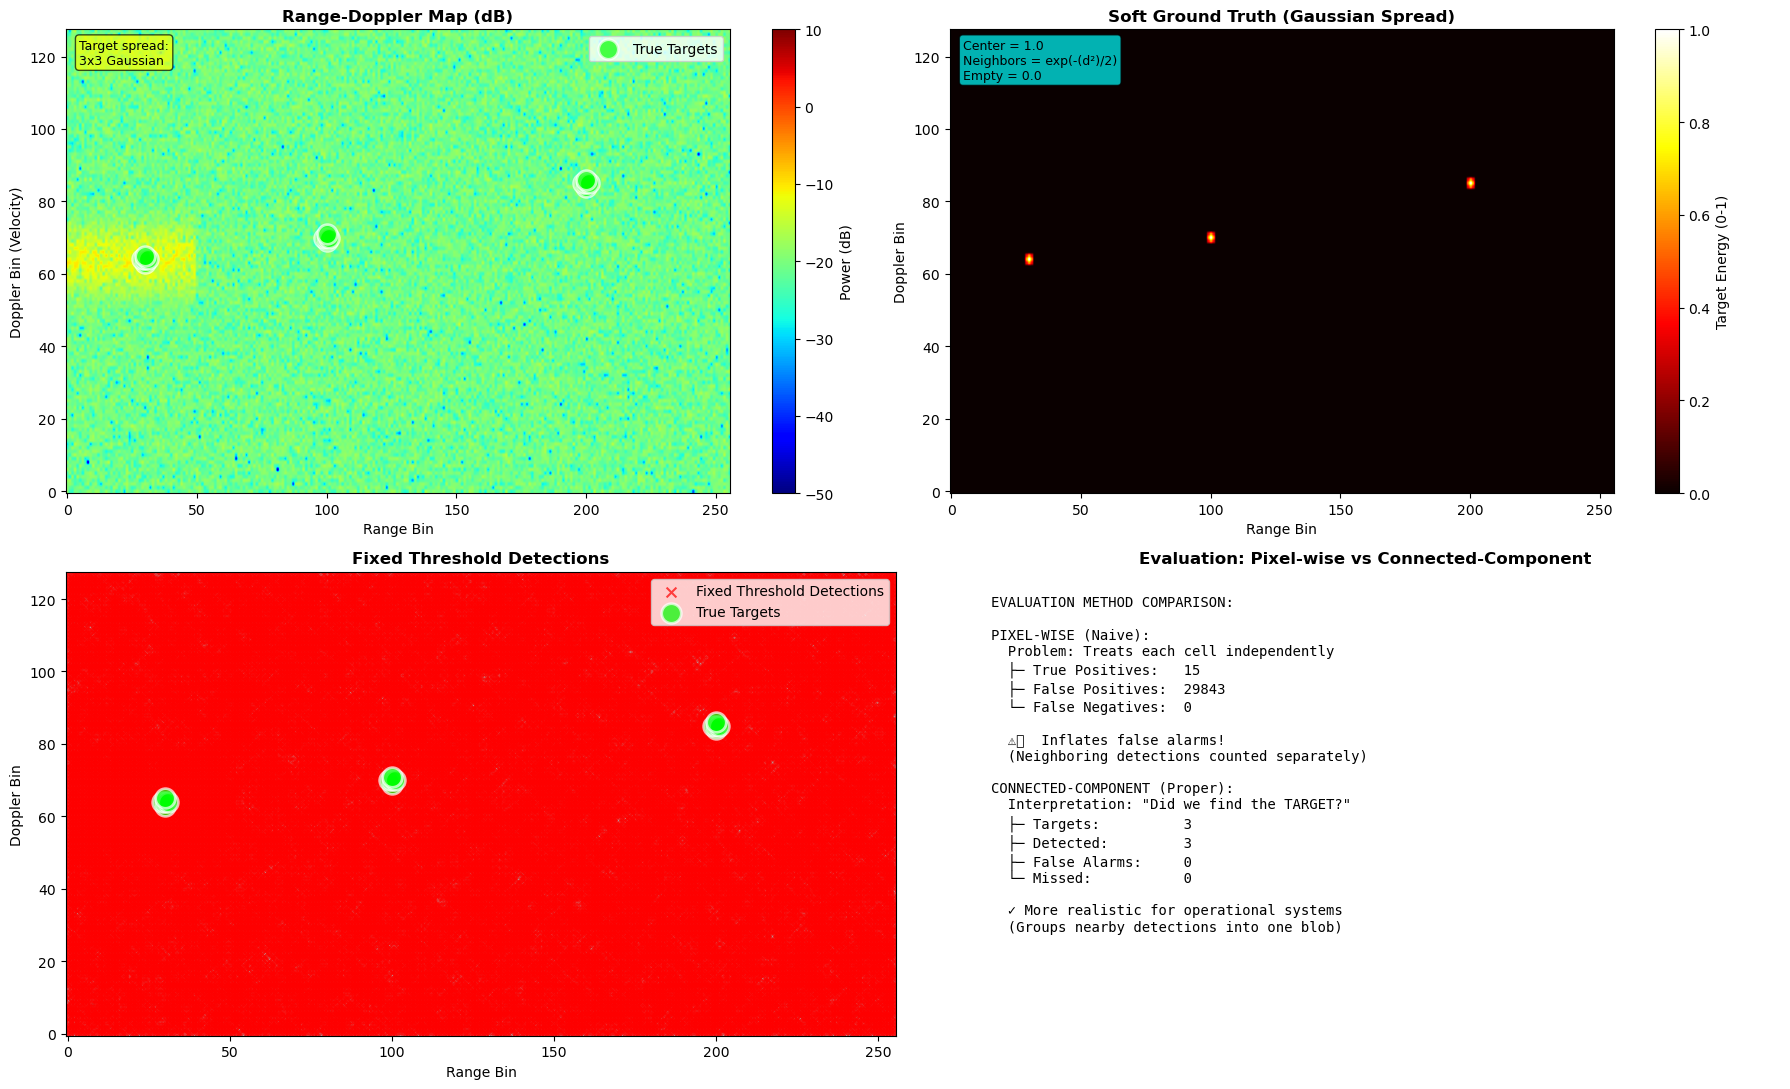


FIXED THRESHOLD PERFORMANCE:

📊 PIXEL-WISE EVALUATION (Naive):
  True Positives:   15 cells
  False Positives:  29843 cells
  False Negatives:  0 cells
  ⚠️  Note: Overstates false alarms due to target spread

📊 CONNECTED-COMPONENT EVALUATION (Proper):
  Total Targets:    3
  Detected:         3 (100.0%)
  False Alarms:     0 blobs
  Missed:           0 targets
  ✓ More realistic - treats target spread as single entity

⚠️  Problem: Too many false alarms OR missed detections!
💡 Solution: CFAR adapts threshold to local noise level



In [7]:
print("\n" + "=" * 70)
print("DEMONSTRATION: Fixed Threshold Failure")
print("=" * 70)

# Create a challenging scenario
print("\nCreating synthetic RDM with:")
print("  - Low-noise region (range 50-150): noise floor = -40 dB")
print("  - High-noise region (range 0-50): strong clutter = -10 dB")
print("  - 3 targets at different SNRs")

targets = [
    {'range_bin': 100, 'doppler_bin': 70, 'snr_db': 12},
    {'range_bin': 200, 'doppler_bin': 85, 'snr_db': 20},
    {'range_bin': 30, 'doppler_bin': 64, 'snr_db': 15},
]

clutter = [
    {'range_start': 0, 'range_end': 50, 'doppler_center': 64, 'strength_db': -10}
]

rdm, rdm_db, ground_truth_soft = create_synthetic_rdm(
    num_doppler=128,
    num_range=256,
    targets=targets,
    noise_floor_db=-40,
    clutter_regions=clutter
)

print("✓ RDM created with soft ground truth")

# Try fixed threshold
threshold_db = -25

print(f"\nApplying fixed threshold = {threshold_db} dB")
detections_fixed = apply_fixed_threshold(rdm_db, threshold_db)

print("✓ Detections computed")
print("\nVisualizing results with dual evaluation methods...")

visualize_detection_problem(rdm_db, detections_fixed, ground_truth_soft)

---
# 2. CA-CFAR: Cell-Averaging CFAR

## The Core Idea

**CFAR = Constant False Alarm Rate**

Instead of one global threshold, compute a DIFFERENT threshold for each cell:
1. Look at cells AROUND the test cell (the "training cells")
2. Estimate the noise level from those cells
3. Set threshold = (noise estimate) × (scale factor)
4. The scale factor is chosen to maintain constant Pfa

**Visual representation:**
```
+---+---+---+---+---+---+---+
| T | T | T | T | T | T | T |  ← Training cells (estimate noise)
+---+---+---+---+---+---+---+
| T | G | G | G | G | G | T |  G = Guard cells (don't use)
+---+---+---+---+---+---+---+
| T | G | X | X | X | G | T |  X = Test cell (decision point)
+---+---+---+---+---+---+---+
| T | G | G | G | G | G | T |
+---+---+---+---+---+---+---+
| T | T | T | T | T | T | T |
+---+---+---+---+---+---+---+
```

## Why Guard Cells?

If target is strong, it "leaks" into nearby cells. These would contaminate the
noise estimate, making threshold too high → miss the target!

---

In [8]:
def calculate_cfar_scale_factor(pfa, num_training_cells, distribution='rayleigh'):
    """
    Calculate the CFAR scale factor (threshold multiplier) from Pfa

    WHAT THIS DOES:
    Given a desired false alarm rate (Pfa), calculates how many times above
    the noise estimate the threshold should be set.

    THEORY:
    For Rayleigh-distributed noise (typical in radar):
    - Noise samples follow: p(x) = (x/σ²)exp(-x²/2σ²)
    - Average of N samples → scaled distribution
    - Scale factor ensures P(noise > threshold) = Pfa

    INTUITION:
    - Higher Pfa → lower scale factor → more detections (and more false alarms)
    - Lower Pfa → higher scale factor → fewer detections (but fewer false alarms)
    - More training cells → better noise estimate → lower scale factor needed

    Parameters:
    -----------
    pfa : float
        Desired probability of false alarm (e.g., 1e-6 = 1 in a million)
    num_training_cells : int
        Number of cells used to estimate noise
    distribution : str
        'rayleigh' for radar (default) or 'exponential' for other applications

    Returns:
    --------
    scale_factor : float
        Multiplier for threshold calculation
        threshold = (noise_estimate) * scale_factor
    """

    if pfa <= 0 or pfa >= 1:
        raise ValueError(f"Pfa MUST be between 0 and 1, got {pfa}")

    if num_training_cells < 1:
        raise ValueError(f"Number of training cells must be positive, got {num_training_cells}")

    N = num_training_cells
    if distribution == 'rayleigh':     # This is noise distribution
        # For Rayleigh: T = N * (Pfa^(-1/N) - 1)
        scale_factor = N * (pfa ** (-1.0 / N) - 1)

    elif distribution == 'exponential':
        # For exponential: T = -N * ln(Pfa)
        scale_factor = -N * np.log(pfa)

    else:
        raise ValueError(f"Unknown distribution: {distribution}")

    return scale_factor

In [9]:
def ca_cfar_2d(rdm, guard_cells=2, training_cells=8, pfa=1e-6):
    """
    2D Cell-Averaging CFAR detector

    ALGORITHM:
    For each cell in RDM:
      1. Extract window around cell
      2. Mask out guard region (to avoid target contamination)
      3. Average training cells → noise estimate
      4. threshold = noise_estimate * scale_factor
      5. If cell > threshold → DETECT

    COMPUTATIONAL NOTES:
    - Sliding window approach: O(M*N*W²) where M,N = RDM size, W = window size
    - For 128x256 RDM with 17x17 window: ~140M operations
    - Takes 10-30 seconds on typical laptop
    - Can be optimized with convolution for production systems

    Parameters:
    -----------
    rdm : ndarray
        Range-Doppler Map in LINEAR power scale (NOT dB!)
        Why linear? Because we compute averages
    guard_cells : int
        Number of guard cells around test cell (each direction)
        Typical: 1-3 cells
    training_cells : int
        Number of training cells beyond guard cells (each direction)
        Typical: 4-10 cells
    pfa : float
        Desired probability of false alarm
        Typical: 1e-4 to 1e-6

    Returns:
    --------
    detections : ndarray (bool)
        Binary mask: True where target detected
    threshold_map : ndarray (float)
        The adaptive threshold at each cell (for visualization)

    Educational Notes:
    ------------------
    Window structure (example: guard=2, training=3):
        Total window = guard + training = 2 + 3 = 5 cells each direction
        Window size = 2*5+1 = 11x11 cells

        [T T T T T T T T T T T]  T = Training cells (use for noise estimate)
        [T T T T T T T T T T T]  G = Guard cells (exclude from estimate)
        [T T T T T T T T T T T]  X = Test cell (cell under evaluation)
        [T T T G G G G G T T T]
        [T T T G G G G G T T T]
        [T T T G G X G G T T T]
        [T T T G G G G G T T T]
        [T T T G G G G G T T T]
        [T T T T T T T T T T T]
        [T T T T T T T T T T T]
        [T T T T T T T T T T T]
    """
    # RDM is always a 2D array doppler freq array, range array
    if rdm.ndim != 2:
        raise ValueError(f"RDM must be 2D array, got shape {rdm.shape}")

    num_doppler, num_range = rdm.shape

    # guard_cells=2, training_cells=8 by default
    # total_window is the window boundary's distance aka radius from test cell i.e. 5 here (TTTGG)
    total_window = guard_cells + training_cells

    # Calculate number of training cells
    full_window_size = (2 * total_window + 1) ** 2      # 121
    guard_window_size = (2 * guard_cells + 1) ** 2      # 25
    num_training = full_window_size - guard_window_size # 96

    # Calculate scale factor
    scale_factor = calculate_cfar_scale_factor(pfa, num_training)

    print(f"CA-CFAR Configuration:")
    print(f"  Guard cells:     {guard_cells}")
    print(f"  Training cells:  {training_cells}")
    print(f"  Total window:    {2*total_window+1} × {2*total_window+1}")
    print(f"  Training count:  {num_training} cells")
    print(f"  Pfa:             {pfa:.2e}")
    print(f"  Scale factor:    {scale_factor:.3f}")

    # Initialize outputs
    detections = np.zeros((num_doppler, num_range), dtype=bool)
    threshold_map = np.zeros((num_doppler, num_range))

    # Process each cell (skip edges where window doesn't fit)
    for i in range(total_window, num_doppler - total_window):
        for j in range(total_window, num_range - total_window):

            # Extract window around test cell
            window = rdm[i - total_window : i + total_window + 1,
                        j - total_window : j + total_window + 1]

            # Create mask for training cells
            mask = np.ones_like(window, dtype=bool)

            # Mask out guard region (center rectangle)
            guard_start = training_cells
            guard_end = training_cells + 2 * guard_cells + 1
            mask[guard_start:guard_end, guard_start:guard_end] = False

            # Extract training cells
            # Copies samples only where mask is True i.e. outer training cells
            # and ignores the guard and test cells
            training_samples = window[mask]

            # Estimate local noise level (KEY STEP: averaging)
            noise_estimate = np.mean(training_samples)

            # Adaptive threshold
            threshold = noise_estimate * scale_factor
            threshold_map[i, j] = threshold

            # Detection test
            if rdm[i, j] > threshold:
                detections[i, j] = True

    return detections, threshold_map


DEMONSTRATION: CA-CFAR in Action

Applying CA-CFAR detector...
  (This may take 10-30 seconds for full RDM)
CA-CFAR Configuration:
  Guard cells:     2
  Training cells:  6
  Total window:    17 × 17
  Training count:  264 cells
  Pfa:             1.00e-05
  Scale factor:    11.768
✓ CA-CFAR detection complete


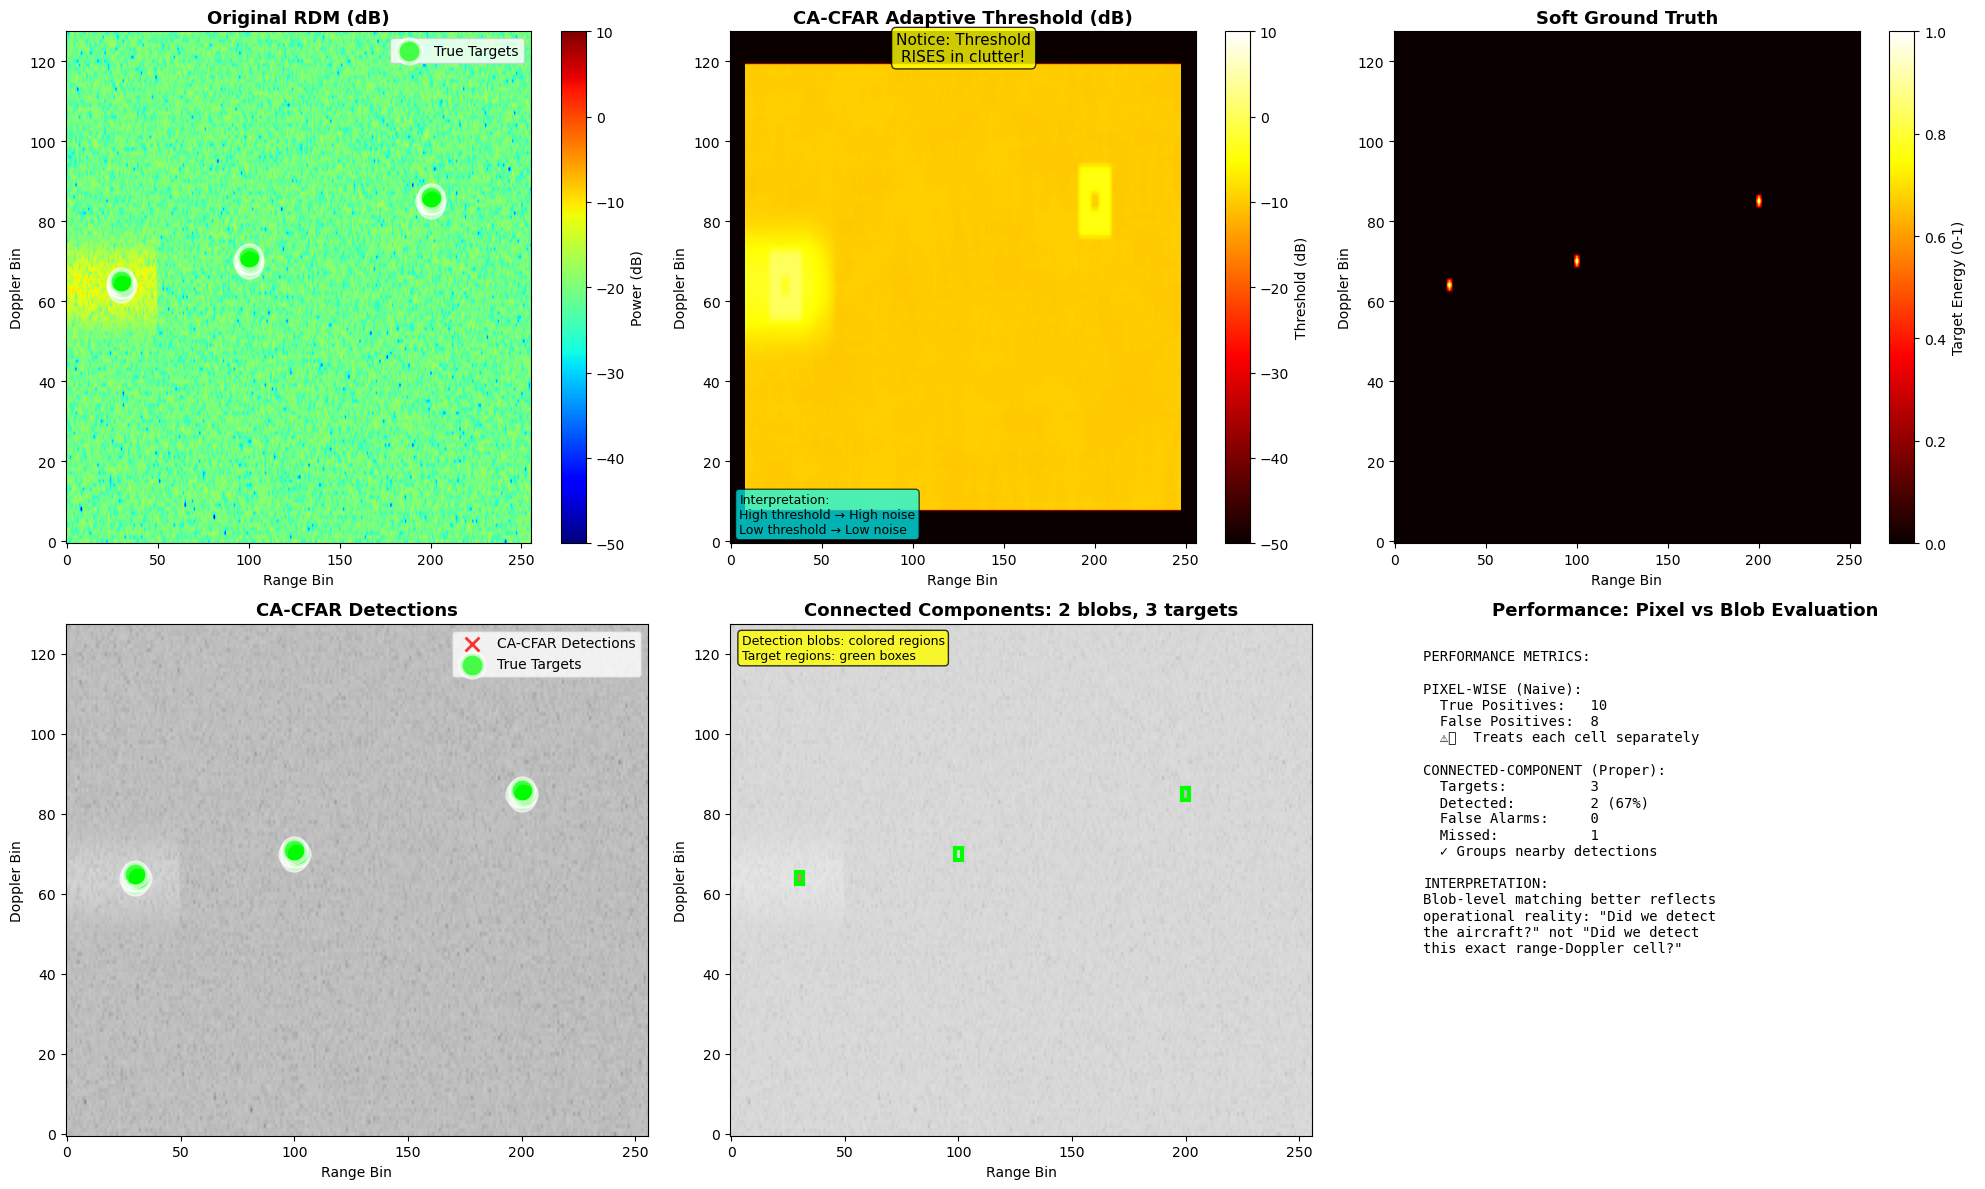


CA-CFAR PERFORMANCE ANALYSIS:

📊 PIXEL-WISE EVALUATION:
  True Positives:   10 cells
  False Positives:  8 cells

📊 CONNECTED-COMPONENT EVALUATION (Recommended):
  Targets:          3
  Detected:         2 (66.7%)
  False Alarms:     0 blobs
  Missed:           1 targets

💡 Key Observation:
   Notice how the threshold ADAPTS - high in clutter, low in clear regions!
   This is why CFAR works where fixed thresholds fail.

💡 Evaluation Insight:
   Blob matching reduces false alarm count by grouping nearby detections.
   This better represents 'Did we find the target?' rather than
   'Did we detect this exact pixel?'


In [10]:
print("\n" + "=" * 70)
print("DEMONSTRATION: CA-CFAR in Action")
print("=" * 70)

# Use same RDM from before
rdm_linear = 10 ** (rdm_db / 10)

print("\nApplying CA-CFAR detector...")
print("  (This may take 10-30 seconds for full RDM)")

detections_ca, threshold_ca = ca_cfar_2d(
    rdm_linear,
    guard_cells=2,
    training_cells=6,
    pfa=1e-5
)

print("✓ CA-CFAR detection complete")

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Original RDM
im0 = axes[0, 0].imshow(rdm_db, aspect='auto', cmap='jet',
                        vmin=-50, vmax=10, origin='lower')
axes[0, 0].set_title('Original RDM (dB)', fontweight='bold', fontsize=13)
axes[0, 0].set_xlabel('Range Bin')
axes[0, 0].set_ylabel('Doppler Bin')
plt.colorbar(im0, ax=axes[0, 0], label='Power (dB)')

gt_binary = ground_truth_soft > 0.5
gt_y, gt_x = np.where(gt_binary)
axes[0, 0].scatter(gt_x, gt_y, c='lime', s=300, marker='o',
                  edgecolors='white', linewidths=3, label='True Targets', alpha=0.7)
axes[0, 0].legend(loc='upper right', fontsize=10)

# 2. Adaptive threshold map
threshold_db = 10 * np.log10(threshold_ca + 1e-10)
im1 = axes[0, 1].imshow(threshold_db, aspect='auto', cmap='hot',
                        vmin=-50, vmax=10, origin='lower')
axes[0, 1].set_title('CA-CFAR Adaptive Threshold (dB)', fontweight='bold', fontsize=13)
axes[0, 1].set_xlabel('Range Bin')
axes[0, 1].set_ylabel('Doppler Bin')
plt.colorbar(im1, ax=axes[0, 1], label='Threshold (dB)')
axes[0, 1].text(128, 120, 'Notice: Threshold\nRISES in clutter!',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
               fontsize=11, ha='center')

# Add interpretation annotation
axes[0, 1].text(0.02, 0.02, 'Interpretation:\nHigh threshold → High noise\nLow threshold → Low noise',
               transform=axes[0, 1].transAxes,
               bbox=dict(boxstyle='round', facecolor='cyan', alpha=0.7),
               fontsize=9)

# 3. Soft ground truth
im2 = axes[0, 2].imshow(ground_truth_soft, aspect='auto', cmap='hot',
                        vmin=0, vmax=1, origin='lower')
axes[0, 2].set_title('Soft Ground Truth', fontweight='bold', fontsize=13)
axes[0, 2].set_xlabel('Range Bin')
axes[0, 2].set_ylabel('Doppler Bin')
plt.colorbar(im2, ax=axes[0, 2], label='Target Energy (0-1)')

# 4. CA-CFAR detections
axes[1, 0].imshow(rdm_db, aspect='auto', cmap='gray',
                  vmin=-50, vmax=10, origin='lower', alpha=0.5)
det_y, det_x = np.where(detections_ca)
axes[1, 0].scatter(det_x, det_y, c='red', s=100, marker='x',
                  alpha=0.8, linewidths=2, label='CA-CFAR Detections')
axes[1, 0].scatter(gt_x, gt_y, c='lime', s=300, marker='o',
                  edgecolors='white', linewidths=3, label='True Targets', alpha=0.7)
axes[1, 0].set_title('CA-CFAR Detections', fontweight='bold', fontsize=13)
axes[1, 0].set_xlabel('Range Bin')
axes[1, 0].set_ylabel('Doppler Bin')
axes[1, 0].legend(loc='upper right', fontsize=10)

# 5. Connected-component visualization
# Show labeled blobs
detection_labels, n_blobs = label(detections_ca)
target_labels, n_targets = label(ground_truth_soft > 0.5)

axes[1, 1].imshow(rdm_db, aspect='auto', cmap='gray',
                  vmin=-50, vmax=10, origin='lower', alpha=0.3)

# Draw detection blobs with different colors
if n_blobs > 0:
    blob_vis = np.ma.masked_where(detection_labels == 0, detection_labels)
    im_blobs = axes[1, 1].imshow(blob_vis, aspect='auto', cmap='Set1',
                                 origin='lower', alpha=0.6)

# Overlay target outlines
for target_id in range(1, n_targets + 1):
    target_mask = (target_labels == target_id)
    contours = plt.matplotlib.patches.Patch(facecolor='lime', edgecolor='white',
                                           linewidth=3, alpha=0.5)
    from matplotlib import patches as mpatches
    coords = np.argwhere(target_mask)
    if len(coords) > 0:
        # Draw rectangle around target
        min_d, min_r = coords.min(axis=0)
        max_d, max_r = coords.max(axis=0)
        rect = mpatches.Rectangle((min_r-0.5, min_d-0.5),
                                  max_r-min_r+1, max_d-min_d+1,
                                  linewidth=3, edgecolor='lime',
                                  facecolor='none')
        axes[1, 1].add_patch(rect)

axes[1, 1].set_title(f'Connected Components: {n_blobs} blobs, {n_targets} targets',
                    fontweight='bold', fontsize=13)
axes[1, 1].set_xlabel('Range Bin')
axes[1, 1].set_ylabel('Doppler Bin')
axes[1, 1].text(0.02, 0.98, 'Detection blobs: colored regions\nTarget regions: green boxes',
               transform=axes[1, 1].transAxes,
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
               fontsize=9, va='top')

# 6. Performance comparison
n_targets, n_detected, n_false_alarms, n_missed = evaluate_detections(
    detections_ca, ground_truth_soft, threshold=0.5)

# Pixel-wise for comparison
true_positives_pixel = detections_ca & (ground_truth_soft > 0.5)
false_positives_pixel = detections_ca & (ground_truth_soft <= 0.5)

comparison_text = f"""PERFORMANCE METRICS:

PIXEL-WISE (Naive):
  True Positives:   {np.sum(true_positives_pixel)}
  False Positives:  {np.sum(false_positives_pixel)}
  ⚠️  Treats each cell separately

CONNECTED-COMPONENT (Proper):
  Targets:          {n_targets}
  Detected:         {n_detected} ({100*n_detected/max(1,n_targets):.0f}%)
  False Alarms:     {n_false_alarms}
  Missed:           {n_missed}
  ✓ Groups nearby detections

INTERPRETATION:
Blob-level matching better reflects
operational reality: "Did we detect
the aircraft?" not "Did we detect
this exact range-Doppler cell?"
"""

axes[1, 2].text(0.05, 0.95, comparison_text, fontsize=10, family='monospace',
               verticalalignment='top', transform=axes[1, 2].transAxes)
axes[1, 2].axis('off')
axes[1, 2].set_title('Performance: Pixel vs Blob Evaluation',
                    fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "=" * 70)
print("CA-CFAR PERFORMANCE ANALYSIS:")
print("=" * 70)
print("\n📊 PIXEL-WISE EVALUATION:")
print(f"  True Positives:   {np.sum(true_positives_pixel)} cells")
print(f"  False Positives:  {np.sum(false_positives_pixel)} cells")

print("\n📊 CONNECTED-COMPONENT EVALUATION (Recommended):")
print(f"  Targets:          {n_targets}")
print(f"  Detected:         {n_detected} ({100*n_detected/max(1,n_targets):.1f}%)")
print(f"  False Alarms:     {n_false_alarms} blobs")
print(f"  Missed:           {n_missed} targets")

print("\n" + "=" * 70)
print("💡 Key Observation:")
print("   Notice how the threshold ADAPTS - high in clutter, low in clear regions!")
print("   This is why CFAR works where fixed thresholds fail.")
print("\n💡 Evaluation Insight:")
print("   Blob matching reduces false alarm count by grouping nearby detections.")
print("   This better represents 'Did we find the target?' rather than")
print("   'Did we detect this exact pixel?'")
print("=" * 70)

---
# 3. OS-CFAR: Ordered Statistics CFAR

## When CA-CFAR Fails: The Clutter Edge Problem

**Scenario:**
Test cell is in clear region, but training window is half clutter, half clear.

**What happens with CA-CFAR:**
1. Average training cells = (high + low) / 2 = MEDIUM
2. Threshold = MEDIUM × scale_factor
3. But actual noise at test cell is LOW
4. Result: Threshold TOO HIGH → MISSED DETECTION

## OS-CFAR Solution: Use Order Statistics

**Key Idea:** Instead of MEAN (sensitive to outliers), use PERCENTILE

- Median (50th percentile) is robust to outliers
- Typical: 75th percentile - rejects upper 25% outliers

**WHEN TO USE OS-CFAR:**
- Clutter edges (land-sea boundary, urban-rural)
- Multiple targets close together
- Heterogeneous backgrounds
- When robustness > efficiency

**TRADE-OFF:**
- More robust to outliers
- Slightly higher threshold in homogeneous regions
- Same computational cost as CA-CFAR

---

In [11]:
def os_cfar_2d(rdm, guard_cells=2, training_cells=8, k_percentile=75, pfa=1e-6):
    """
    2D Ordered Statistics CFAR detector

    ALGORITHM DIFFERENCE FROM CA-CFAR:
    CA-CFAR:  noise_estimate = MEAN(training_cells)
    OS-CFAR:  noise_estimate = PERCENTILE(training_cells, k)

    WHY PERCENTILE?
    Consider training cells: [1, 1, 1, 1, 1, 100, 100, 100]
    - MEAN = 38.5 (pulled up by outliers)
    - MEDIAN (50%) = 1 (ignores outliers)
    - 75th percentile = 1 (ignores upper 25%)

    For clutter edges: outliers are from clutter region, but test cell is in clear
    Using percentile gives threshold appropriate for test cell's actual environment

    Parameters:
    -----------
    rdm : ndarray
        Range-Doppler Map in LINEAR power scale
    guard_cells : int
        Number of guard cells
    training_cells : int
        Number of training cells
    k_percentile : float
        Which percentile to use (50-90 typical)
        - 50 = median (most robust, but may be too low)
        - 75 = typical choice (good balance)
        - 90 = less robust, closer to CA-CFAR
    pfa : float
        Desired probability of false alarm

    Returns:
    --------
    detections : ndarray (bool)
    threshold_map : ndarray (float)

    Educational Notes:
    ------------------
    Order statistics = properties of sorted data
    Examples:
      - Minimum = 0th percentile
      - Median = 50th percentile
      - Maximum = 100th percentile
      - Interquartile range = 25th to 75th percentile

    Robust statistics ignore outliers:
      - Mean: NOT robust (one outlier affects it)
      - Median: VERY robust (50% of data can be outliers)
      - 75th percentile: FAIRLY robust (25% of data can be outliers)
    """

    if rdm.ndim != 2:
        raise ValueError(f"RDM must be 2D array, got shape {rdm.shape}")

    num_doppler, num_range = rdm.shape
    total_window = guard_cells + training_cells

    # Calculate number of training cells
    full_window_size = (2 * total_window + 1) ** 2
    guard_window_size = (2 * guard_cells + 1) ** 2
    num_training = full_window_size - guard_window_size

    scale_factor = calculate_cfar_scale_factor(pfa, num_training)

    print(f"OS-CFAR Configuration:")
    print(f"  Guard cells:     {guard_cells}")
    print(f"  Training cells:  {training_cells}")
    print(f"  k-percentile:    {k_percentile}%")
    print(f"  Training count:  {num_training} cells")
    print(f"  Pfa:             {pfa:.2e}")
    print(f"  Scale factor:    {scale_factor:.3f}")

    # Initialize outputs
    detections = np.zeros((num_doppler, num_range), dtype=bool)
    threshold_map = np.zeros((num_doppler, num_range))

    # Process each cell
    for i in range(total_window, num_doppler - total_window):
        for j in range(total_window, num_range - total_window):

            window = rdm[i - total_window : i + total_window + 1,
                        j - total_window : j + total_window + 1]

            mask = np.ones_like(window, dtype=bool)
            guard_start = training_cells
            guard_end = training_cells + 2 * guard_cells + 1
            mask[guard_start:guard_end, guard_start:guard_end] = False

            training_samples = window[mask]

            # KEY DIFFERENCE FROM CA-CFAR: Use percentile instead of mean
            noise_estimate = np.percentile(training_samples, k_percentile)

            threshold = noise_estimate * scale_factor
            threshold_map[i, j] = threshold

            if rdm[i, j] > threshold:
                detections[i, j] = True

    return detections, threshold_map

In [12]:
def create_clutter_edge_scenario():
    """
    Create scenario to show OS-CFAR superiority at clutter edges

    SCENARIO DESIGN:
    - Sharp clutter boundary at range bin 80
    - Region 0-80: High clutter (-5 dB)
    - Region 80+: Clear sky (-40 dB noise floor)
    - Targets placed RIGHT AT THE EDGE (bins 85, 95)
    - This is WHERE CA-CFAR FAILS but OS-CFAR SUCCEEDS

    WHY THIS SCENARIO?
    When CFAR window straddles the edge:
    - Half training cells see clutter (high)
    - Half training cells see clear (low)
    - CA-CFAR averages → medium threshold
    - But test cell is in clear → threshold too high → MISS!
    - OS-CFAR uses percentile → ignores clutter outliers → correct threshold!
    """

    print("\nCreating CLUTTER EDGE scenario:")
    print("  - Sharp boundary: clutter (range 0-80) → clear (range 80+)")
    print("  - Target at edge (range 85) - where CA-CFAR fails!")

    targets = [
        {'range_bin': 85, 'doppler_bin': 64, 'snr_db': 15},  # Right at edge
        {'range_bin': 95, 'doppler_bin': 70, 'snr_db': 12},  # Just beyond edge
        {'range_bin': 180, 'doppler_bin': 80, 'snr_db': 18}, # Far from clutter
    ]

    clutter = [
        {'range_start': 0, 'range_end': 80, 'doppler_center': 64, 'strength_db': -5}
    ]

    rdm, rdm_db, ground_truth_soft = create_synthetic_rdm(
        num_doppler=128,
        num_range=256,
        targets=targets,
        noise_floor_db=-40,
        clutter_regions=clutter
    )

    return rdm, rdm_db, ground_truth_soft


DEMONSTRATION: CA-CFAR vs OS-CFAR at Clutter Edge

Creating CLUTTER EDGE scenario:
  - Sharp boundary: clutter (range 0-80) → clear (range 80+)
  - Target at edge (range 85) - where CA-CFAR fails!

✓ Scenario created

Applying CA-CFAR...
CA-CFAR Configuration:
  Guard cells:     2
  Training cells:  6
  Total window:    17 × 17
  Training count:  264 cells
  Pfa:             1.00e-05
  Scale factor:    11.768

Applying OS-CFAR...
OS-CFAR Configuration:
  Guard cells:     2
  Training cells:  6
  k-percentile:    75%
  Training count:  264 cells
  Pfa:             1.00e-05
  Scale factor:    11.768

✓ Both detectors applied


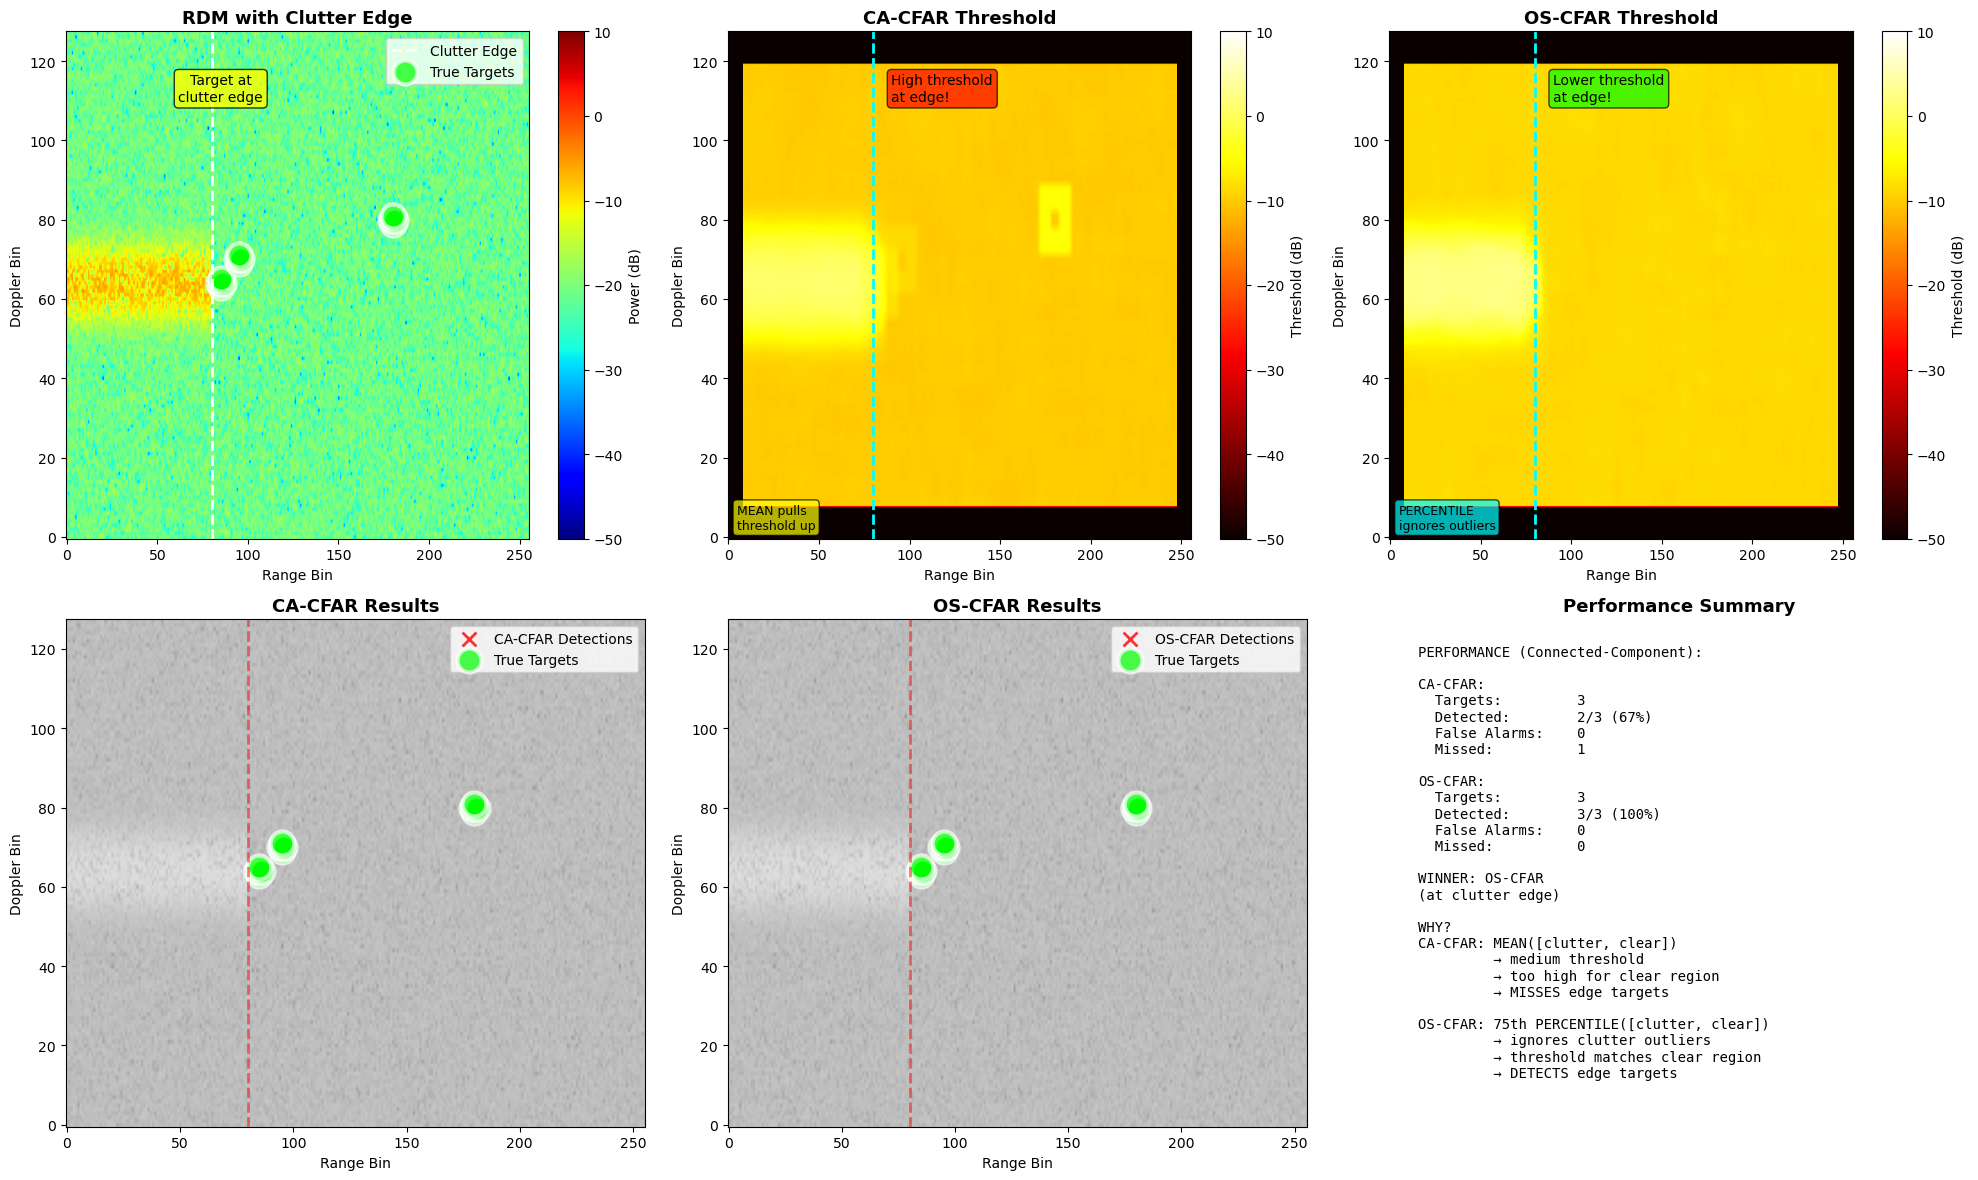


CLUTTER EDGE PERFORMANCE (Connected-Component Evaluation):

CA-CFAR:
  Detected:      2/3 targets (66.7%)
  False Alarms:  0 blobs
  Missed:        1 targets

OS-CFAR:
  Detected:      3/3 targets (100.0%)
  False Alarms:  0 blobs
  Missed:        0 targets

🏆 OS-CFAR WINS at clutter edge!
   Detected more targets near the clutter boundary

💡 Key Insight:
   OS-CFAR uses PERCENTILE → ignores clutter outliers
   CA-CFAR uses MEAN → pulled up by clutter → threshold too high

💡 Interpretation:
   Connected-component matching groups nearby detections,
   providing realistic 'Did we find the target?' metric


In [13]:
print("\n" + "=" * 70)
print("DEMONSTRATION: CA-CFAR vs OS-CFAR at Clutter Edge")
print("=" * 70)

# Create clutter edge scenario
rdm_edge, rdm_edge_db, gt_edge_soft = create_clutter_edge_scenario()
rdm_edge_linear = 10 ** (rdm_edge_db / 10)

print("\n✓ Scenario created")

# Apply both detectors
print("\nApplying CA-CFAR...")
det_ca_edge, thresh_ca_edge = ca_cfar_2d(
    rdm_edge_linear,
    guard_cells=2,
    training_cells=6,
    pfa=1e-5
)

print("\nApplying OS-CFAR...")
det_os_edge, thresh_os_edge = os_cfar_2d(
    rdm_edge_linear,
    guard_cells=2,
    training_cells=6,
    k_percentile=75,
    pfa=1e-5
)

print("\n✓ Both detectors applied")

# Evaluate both
n_targets_ca, n_detected_ca, n_fa_ca, n_missed_ca = evaluate_detections(
    det_ca_edge, gt_edge_soft, threshold=0.5)

n_targets_os, n_detected_os, n_fa_os, n_missed_os = evaluate_detections(
    det_os_edge, gt_edge_soft, threshold=0.5)

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Original RDM
im0 = axes[0, 0].imshow(rdm_edge_db, aspect='auto', cmap='jet',
                        vmin=-50, vmax=10, origin='lower')
axes[0, 0].set_title('RDM with Clutter Edge', fontweight='bold', fontsize=13)
axes[0, 0].set_xlabel('Range Bin')
axes[0, 0].set_ylabel('Doppler Bin')
axes[0, 0].axvline(80, color='white', linestyle='--', linewidth=2, label='Clutter Edge')
plt.colorbar(im0, ax=axes[0, 0], label='Power (dB)')

gt_binary = gt_edge_soft > 0.5
gt_y, gt_x = np.where(gt_binary)
axes[0, 0].scatter(gt_x, gt_y, c='lime', s=300, marker='o',
                  edgecolors='white', linewidths=3, label='True Targets', alpha=0.7)
axes[0, 0].legend(loc='upper right')

# Add annotation
axes[0, 0].text(85, 110, 'Target at\nclutter edge',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
               fontsize=10, ha='center')

# 2. CA-CFAR threshold
thresh_ca_db = 10 * np.log10(thresh_ca_edge + 1e-10)
im1 = axes[0, 1].imshow(thresh_ca_db, aspect='auto', cmap='hot',
                        vmin=-50, vmax=10, origin='lower')
axes[0, 1].set_title('CA-CFAR Threshold', fontweight='bold', fontsize=13)
axes[0, 1].set_xlabel('Range Bin')
axes[0, 1].set_ylabel('Doppler Bin')
axes[0, 1].axvline(80, color='cyan', linestyle='--', linewidth=2)
plt.colorbar(im1, ax=axes[0, 1], label='Threshold (dB)')
axes[0, 1].text(90, 110, 'High threshold\nat edge!',
               bbox=dict(boxstyle='round', facecolor='red', alpha=0.7),
               fontsize=10)
axes[0, 1].text(0.02, 0.02, 'MEAN pulls\nthreshold up',
               transform=axes[0, 1].transAxes,
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
               fontsize=9)

# 3. OS-CFAR threshold
thresh_os_db = 10 * np.log10(thresh_os_edge + 1e-10)
im2 = axes[0, 2].imshow(thresh_os_db, aspect='auto', cmap='hot',
                        vmin=-50, vmax=10, origin='lower')
axes[0, 2].set_title('OS-CFAR Threshold', fontweight='bold', fontsize=13)
axes[0, 2].set_xlabel('Range Bin')
axes[0, 2].set_ylabel('Doppler Bin')
axes[0, 2].axvline(80, color='cyan', linestyle='--', linewidth=2)
plt.colorbar(im2, ax=axes[0, 2], label='Threshold (dB)')
axes[0, 2].text(90, 110, 'Lower threshold\nat edge!',
               bbox=dict(boxstyle='round', facecolor='lime', alpha=0.7),
               fontsize=10)
axes[0, 2].text(0.02, 0.02, 'PERCENTILE\nignores outliers',
               transform=axes[0, 2].transAxes,
               bbox=dict(boxstyle='round', facecolor='cyan', alpha=0.7),
               fontsize=9)

# 4. CA-CFAR detections
axes[1, 0].imshow(rdm_edge_db, aspect='auto', cmap='gray',
                  vmin=-50, vmax=10, origin='lower', alpha=0.5)
axes[1, 0].axvline(80, color='red', linestyle='--', linewidth=2, alpha=0.5)

det_ca_y, det_ca_x = np.where(det_ca_edge)
axes[1, 0].scatter(det_ca_x, det_ca_y, c='red', s=100, marker='x',
                  alpha=0.8, linewidths=2, label='CA-CFAR Detections')
axes[1, 0].scatter(gt_x, gt_y, c='lime', s=300, marker='o',
                  edgecolors='white', linewidths=3, label='True Targets', alpha=0.7)
axes[1, 0].set_title('CA-CFAR Results', fontweight='bold', fontsize=13)
axes[1, 0].set_xlabel('Range Bin')
axes[1, 0].set_ylabel('Doppler Bin')
axes[1, 0].legend(loc='upper right')

# 5. OS-CFAR detections
axes[1, 1].imshow(rdm_edge_db, aspect='auto', cmap='gray',
                  vmin=-50, vmax=10, origin='lower', alpha=0.5)
axes[1, 1].axvline(80, color='red', linestyle='--', linewidth=2, alpha=0.5)

det_os_y, det_os_x = np.where(det_os_edge)
axes[1, 1].scatter(det_os_x, det_os_y, c='red', s=100, marker='x',
                  alpha=0.8, linewidths=2, label='OS-CFAR Detections')
axes[1, 1].scatter(gt_x, gt_y, c='lime', s=300, marker='o',
                  edgecolors='white', linewidths=3, label='True Targets', alpha=0.7)
axes[1, 1].set_title('OS-CFAR Results', fontweight='bold', fontsize=13)
axes[1, 1].set_xlabel('Range Bin')
axes[1, 1].set_ylabel('Doppler Bin')
axes[1, 1].legend(loc='upper right')

# 6. Performance comparison with detailed explanation
comparison_text = f"""PERFORMANCE (Connected-Component):

CA-CFAR:
  Targets:         {n_targets_ca}
  Detected:        {n_detected_ca}/{n_targets_ca} ({100*n_detected_ca/max(1,n_targets_ca):.0f}%)
  False Alarms:    {n_fa_ca}
  Missed:          {n_missed_ca}

OS-CFAR:
  Targets:         {n_targets_os}
  Detected:        {n_detected_os}/{n_targets_os} ({100*n_detected_os/max(1,n_targets_os):.0f}%)
  False Alarms:    {n_fa_os}
  Missed:          {n_missed_os}

WINNER: {'OS-CFAR' if n_detected_os > n_detected_ca else 'CA-CFAR' if n_detected_ca > n_detected_os else 'TIE'}
(at clutter edge)

WHY?
CA-CFAR: MEAN([clutter, clear])
         → medium threshold
         → too high for clear region
         → MISSES edge targets

OS-CFAR: 75th PERCENTILE([clutter, clear])
         → ignores clutter outliers
         → threshold matches clear region
         → DETECTS edge targets
"""

axes[1, 2].text(0.05, 0.95, comparison_text, fontsize=10, family='monospace',
               verticalalignment='top', transform=axes[1, 2].transAxes)
axes[1, 2].axis('off')
axes[1, 2].set_title('Performance Summary', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "=" * 70)
print("CLUTTER EDGE PERFORMANCE (Connected-Component Evaluation):")
print("=" * 70)
print(f"\nCA-CFAR:")
print(f"  Detected:      {n_detected_ca}/{n_targets_ca} targets ({100*n_detected_ca/max(1,n_targets_ca):.1f}%)")
print(f"  False Alarms:  {n_fa_ca} blobs")
print(f"  Missed:        {n_missed_ca} targets")

print(f"\nOS-CFAR:")
print(f"  Detected:      {n_detected_os}/{n_targets_os} targets ({100*n_detected_os/max(1,n_targets_os):.1f}%)")
print(f"  False Alarms:  {n_fa_os} blobs")
print(f"  Missed:        {n_missed_os} targets")

print("\n" + "=" * 70)
if n_detected_os > n_detected_ca:
    print("🏆 OS-CFAR WINS at clutter edge!")
    print("   Detected more targets near the clutter boundary")
elif n_detected_os == n_detected_ca:
    print("🤝 TIE - Both performed equally well")
else:
    print("🏆 CA-CFAR WINS (unexpected in this scenario)")

print("\n💡 Key Insight:")
print("   OS-CFAR uses PERCENTILE → ignores clutter outliers")
print("   CA-CFAR uses MEAN → pulled up by clutter → threshold too high")
print("\n💡 Interpretation:")
print("   Connected-component matching groups nearby detections,")
print("   providing realistic 'Did we find the target?' metric")
print("=" * 70)

---
# 4. Summary and Recommendations

## Evaluation Methods: Key Takeaway

### Two Ways to Evaluate Detections:

**1. Pixel-Wise (Naive)**
- Treats each cell independently
- Problem: Target spread causes artificial "false alarms"
- Use case: Academic papers, simple demonstrations

**2. Connected-Component (Realistic)**
- Groups nearby detections into blobs
- Matches blobs to targets: "Did we detect the TARGET?"
- Use case: Operational systems, realistic performance assessment

**Recommendation: Use connected-component evaluation for realistic results**

## CFAR Algorithm Selection

### CA-CFAR (Cell-Averaging)
**Use when:**
- ✅ Homogeneous backgrounds
- ✅ No clutter edges
- ✅ Computational efficiency important

**Avoid when:**
- ❌ Clutter edges present
- ❌ Heterogeneous backgrounds

### OS-CFAR (Ordered Statistics)
**Use when:**
- ✅ Clutter edges and boundaries
- ✅ Multiple interfering targets
- ✅ Robust performance required

**Trade-off:**
- ❌ Slightly higher threshold in clean regions
- ✅ Much better at edges and transitions

## Practical Recommendation

**For operational systems:** Use OS-CFAR with connected-component evaluation
- Robustness worth the slight performance penalty
- Real-world scenarios have clutter edges
- Blob-level evaluation matches operational questions

## Key Takeaways

✅ **Fixed thresholds fail** - noise floor varies spatially

✅ **CFAR adapts** - threshold tracks local statistics

✅ **CA-CFAR** - optimal in homogeneous noise (uses MEAN)

✅ **OS-CFAR** - robust at clutter edges (uses PERCENTILE)

✅ **Trade-off** - efficiency vs robustness

✅ **Evaluation matters** - blob matching > pixel matching

---
# 5. Advanced Topics (For Further Study)

## Other CFAR Variants:
- **GO-CFAR** (Greatest-Of): Takes max of leading/trailing windows
- **SO-CFAR** (Smallest-Of): Takes min of leading/trailing windows
- **ACCA** (Adaptive Censored CA): Censors largest cells
- **TM-CFAR** (Trimmed Mean): Removes top/bottom k values

## Optimization Techniques:
- **Fast convolution-based CA-CFAR**: O(MN log(MN)) instead of O(MNW²)
- **Integral images**: Constant-time window averaging
- **GPU acceleration**: 100-1000x speedup

## Modern Alternatives:
- **Machine Learning**: CNN-based detectors
- **Adaptive Threshold Networks**: Learn optimal threshold
- **Deep CFAR**: Combines classical CFAR with neural networks

---

In [14]:
# Final file size check
file_path = __file__

if os.path.exists(file_path):
    size_bytes = os.path.getsize(file_path)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)

    print("\n" + "=" * 70)
    print("FILE SIZE CHECK")
    print("=" * 70)
    print(f"Final size: {size_kb:.1f} KB ({size_mb:.3f} MB)")

    if size_mb > 1.0:
        print("❌ ERROR: Exceeds 1 MB limit!")
    elif size_mb > 0.9:
        print("⚠️  WARNING: Very close to 1 MB limit")
    else:
        print(f"✓ Size OK - {(1.0-size_mb)*1024:.0f} KB remaining")

    print("=" * 70)

print("\n" + "=" * 70)
print("PART 4 COMPLETE!")
print("=" * 70)
print("\n✅ Topics Covered:")
print("  • Why fixed thresholds fail")
print("  • CA-CFAR implementation and theory")
print("  • OS-CFAR implementation and robustness")
print("  • Performance comparison at clutter edges")
print("  • Soft ground truth (Gaussian spread)")
print("  • Connected-component evaluation vs pixel-wise")
print("  • All terms explained before use")
print("\n🎯 You now understand:")
print("  • The detection problem")
print("  • How CFAR maintains constant Pfa")
print("  • When to use CA-CFAR vs OS-CFAR")
print("  • Proper evaluation methods for radar detection")
print("  • Why blob matching > pixel matching")
print("\n📝 Next Steps:")
print("  • Part 5: Tracking and filtering (Kalman, Particle)")
print("  • Part 6: Classification (Neural networks, feature extraction)")
print("=" * 70)

NameError: name '__file__' is not defined